In [1]:
import mdtraj as md
import pyemma as pm
import openpathsampling as ops

from pathlib import Path
import os
import pickle
import pandas 
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
seed = 49587
rng = np.random.default_rng(seed)
protein = 'CLN'

# Paths
top_path = Path('./data/CLN_msm//protein.pdb')
traj_paths = [str(x) for x in Path(r'./data/CLN_msm/').rglob(f'CLN025-0-protein-*.xtc')]
traj_paths.sort()
model_path = Path(r'./data/CLN_msm/')

# MSM parameters
f_scheme = 'ca'
tica_lag = 3
tica_d = 15
cluster_n = 469
cluster_stride = 1
max_iter = 1000
msm_lag = 31

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

In [6]:
# MSM & pcca

ftrajs = []
for traj_path in traj_paths:
    traj = md.load(traj_path, top=top_path)
    ftrajs.append(md.compute_contacts(traj, scheme=f_scheme)[0])

tica_mod = pm.coordinates.tica(ftrajs, lag=tica_lag, dim=tica_d, kinetic_map=True)
ttrajs = tica_mod.get_output()

kmeans_mod = pm.coordinates.cluster_kmeans(ttrajs, k=cluster_n, max_iter=max_iter, stride=cluster_stride, fixed_seed=seed)
dtrajs = kmeans_mod.dtrajs

msm = pm.msm.estimate_markov_model(dtrajs, lag=msm_lag)
_ = msm.pcca(n_sets)

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|     | 0/54 [00:00<?, ?it/s]

getting output of TICA:   0%|    | 0/54 [00:00<?, ?it/s]

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?it

kmeans iterations:   0%|       | 0/1000 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%| | 0/54 [00:00<

/tmp/ipykernel_81435/3327657396.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  core_sets = np.array(ix_ls)


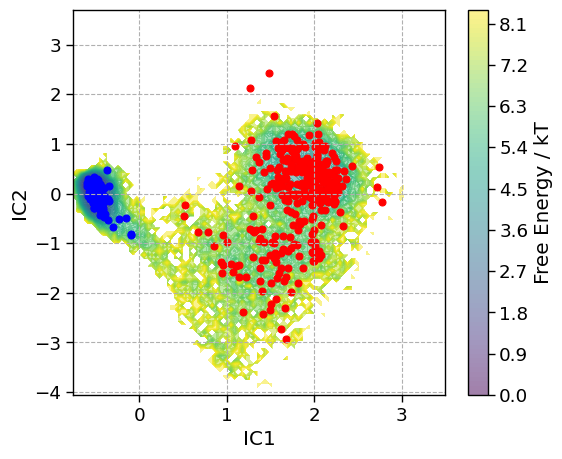

In [22]:
# Compute core set 
# Visualise FES and core sets

ix_ls = []
core_memberships = msm.metastable_memberships.T > core_membership_cutoff
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

Y = np.concatenate(ttrajs)
x = kmeans_mod.clustercenters[:, 0]
y = kmeans_mod.clustercenters[:, 1]  

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    ax.grid(visible=True, axis='both', ls='--')
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=ax)
    for i_set in range(n_sets):
        ms = ax.scatter(x=x[core_sets[i_set]], y=y[core_sets[i_set]], c=['r','b','m'][i_set],
                          label=f'{i_set+1}', s=25)
    
    ax.set_xlabel('IC1')
    ax.set_ylabel('IC2')
    plt.savefig(model_path.joinpath('FES.png'))
    plt.show()

In [ ]:
# Sava tica_mod and kmeans_mod objects 

with open(os.path.join(model_path, 'msm_models'), 'wb') as f:
    pickle.dump({'tica_mod':tica_mod, 'kmeans_mod':kmeans_mod, 'msm':msm}, f)